# Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Features engineering

-> toutes les données de users
-> mois
-> toutes les triplets d'actions possibles
-> time_elapsed
-> 

In [38]:
# Import data
users = pd.read_csv('data/train_users_2.csv')
test_users = pd.read_csv('data/test_users.csv')
sessions = pd.read_csv('data/sessions.csv')

# Add labels DF/NDF
users['destination_found'] = users.apply(lambda r: 'NDF' if r['country_destination'] == 'NDF' else 'DF', axis=1)

# Retain users that have a session & add information about their session
sessions['action_name'] = sessions.fillna('').apply(lambda r: r['action']+"-"+r["action_type"]+"-"+r["action_detail"], axis=1)
users_sessions = sessions.groupby('user_id').agg({
    "action_name": pd.Series.tolist,
    'secs_elapsed': lambda r: round(r.sum() / (60**2), 0),
})
users_sessions = users_sessions.rename({"secs_elapsed":"hours_elapsed", "action_name":"actions",}, axis=1)
users = users_sessions.reset_index().rename({'user_id':'id'}, axis=1).merge(users, how='inner', on='id')

# Make dataset balanced by keeping the smae number users in each classes
n = min(users[users['destination_found'] == 'NDF'].shape[0], users[users['destination_found'] == 'DF'].shape[0])
users = pd.concat([users[users['destination_found'] == 'NDF'].head(n), users[users['destination_found'] == 'DF'].head(n)]).sample(frac=1).reset_index(drop=True)

In [39]:
users

,id,actions,hours_elapsed,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,destination_found
0,ftlkwqfb5l,"[search_results-click-view_search_results, ind...",295.0,2014-06-01,20140601130516,NaN,MALE,52.0,basic,0,en,direct,direct,linked,Web,Mac Desktop,Safari,NDF,NDF
1,9vcm42micq,"[campaigns--, -message_post-message_post, acti...",27.0,2014-06-18,20140618222804,NaN,-unknown-,NaN,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF,NDF
2,0isxdsrx9w,"[show--, show-view-p3, lookup--, search_result...",1396.0,2014-03-30,20140330051533,NaN,-unknown-,58.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari,NDF,NDF
3,lh518avjt5,"[confirm_email-click-confirm_email_link, heade...",190.0,2014-06-11,20140611050258,NaN,MALE,19.0,basic,0,en,sem-brand,google,omg,Web,Windows Desktop,Chrome,NDF,NDF
4,bfr75lo8sa,"[dashboard-view-dashboard, header_userpic-data...",255.0,2014-03-08,20140308191046,2014-03-11,MALE,35.0,basic,0,en,direct,direct,untracked,Web,Windows Desktop,Chrome,US,DF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57543,888978vjbk,"[show--unknown---unknown-, reviews-data-listin...",15.0,2014-06-23,20140623234642,NaN,FEMALE,20.0,basic,25,en,direct,direct,untracked,iOS,iPhone,-unknown-,NDF,NDF
57544,ak84cqisga,"[show-view-p3, index-view-view_search_results,...",390.0,2014-05-17,20140517154747,NaN,MALE,24.0,basic,0,fr,direct,direct,omg,Web,Windows Desktop,Chrome,NDF,NDF
57545,fmmch5nrkx,"[search_results-click-view_search_results, sea...",847.0,2014-04-08,20140408154419,2014-04-09,MALE,33.0,facebook,0,en,direct,direct,untracked,Web,Windows Desktop,Chrome,US,DF
57546,qkb5623x13,"[edit-view-edit_profile, search_results-click-...",131.0,2014-03-24,20140324025224,2014-03-25,MALE,31.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US,DF


In [40]:
# Converting date string into datetime object
users['timestamp_first_active'] = pd.to_datetime(users['timestamp_first_active'], format='%Y%m%d%H%M%S')
users['date_account_created'] = pd.to_datetime(users['date_account_created'], format='%Y-%m-%d')
users["date_first_booking"] = pd.to_datetime(users['date_first_booking'], format='%Y-%m-%d')
users['date_first_active'] = pd.to_datetime(users['timestamp_first_active'].dt.date, format='%Y-%m-%d')
users['hour_first_active'] = users['timestamp_first_active'].dt.hour
users['month_first_active'] = users['date_first_active'].dt.month
users['year_first_active'] = users['date_first_active'].dt.year

In [41]:
def process_age(age):
    if age > 1000:
        return 2015 - age
    elif age < 100:
        return age
    else: 
        return -1

# Bucketize age variable
users['age'] = users.apply(lambda r: process_age(r['age']), axis=1)
users['age_group'] = sum([(users['age'] < 0).astype(int),
    (users['age'] < 18).astype(int),
    (users['age'] < 25).astype(int),
    (users['age'] < 30).astype(int),
    (users['age'] < 35).astype(int),
    (users['age'] < 40).astype(int),
    (users['age'] < 60).astype(int),
    (users['age'] < 100).astype(int)])

In [42]:
def process_signup_flow(num_page):
    if num_page <= 3:
        return num_page
    elif 3 < num_page < 12:
        return 'middle'
    else:
        return 12
    
# Bucketize signup_flow
users['signup_flow_group'] = users.apply(lambda r: process_signup_flow(r['signup_flow']), axis=1)

In [65]:
# Bucketize language
users['language_group'] = (users['language'] == 'en').astype(int)

In [43]:
# Only retains browser which have a large enough set of users
users_browsers = users.groupby('first_browser').count()[['id']].sort_values(by='id')
browsers = set(users_browsers[users_browsers['id'] > 1000].index)
users['first_browser_processed'] = users.apply(lambda r: r['first_browser'] if r['first_browser'] in browsers else 'Other', axis=1)

In [66]:
# Selecting features
features = ['month_first_active', 'year_first_active', 'gender', 'age_group', 'signup_method', 'signup_flow_group', 'affiliate_channel', 'affiliate_provider', 
           'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser_processed', 'language_group']

data = users[features].copy()

X = pd.get_dummies(data)
y = users['destination_found'].values
# y = users['country_destination'].values

## Training model

In [67]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=50, max_depth=12)
res = cross_val_score(model, X=X, y=y)
print(f"Mean score : {np.mean(res)}")
print(f"Std score : {np.std(res)}")

Mean score : 0.7066794913420608
Std score : 0.004418678558354274


In [56]:
y

array(['NDF', 'NDF', 'NDF', ..., 'DF', 'DF', 'DF'], dtype=object)

[[0.73009619 0.26990381]
 [0.32874016 0.67125984]]


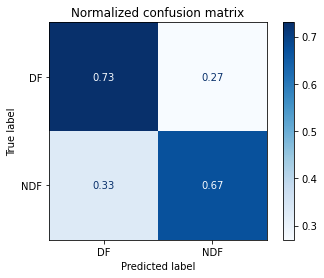

In [64]:
from sklearn.metrics import plot_confusion_matrix
n = int(X.shape[0] * 0.7)
model.fit(X[:n], y[:n])

# Plot non-normalized confusion matrix
disp = plot_confusion_matrix(model, X[n:], y[n:], cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title("Normalized confusion matrix")
print(disp.confusion_matrix)